In [ ]:
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE1 = 113
IMAGE_SIZE2 = 150
CHANNELS=3
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/FINAL_DATASET_CROP_MONITORING",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 3023 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 113, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import numpy as np
labels=[]
array1 = np.array([])
for image_batch, labels_batch in test_ds:
  labels.append(labels_batch.numpy())
for i in range(10):
  array1=np.append(array1,labels[i])
lable_list=array1.tolist()


In [ ]:
len(lable_list)

320

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE1, IMAGE_SIZE2),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(113,150,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
76/76 [==============================] - 259s 2s/step - loss: 0.1666 - accuracy: 0.9495 - val_loss: 0.1498 - val_accuracy: 0.9688
Epoch 2/10
76/76 [==============================] - 241s 2s/step - loss: 0.0629 - accuracy: 0.9793 - val_loss: 0.0101 - val_accuracy: 0.9963
Epoch 3/10
76/76 [==============================] - 238s 2s/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0308 - val_accuracy: 0.9965
Epoch 4/10
76/76 [==============================] - 238s 2s/step - loss: 0.0083 - accuracy: 0.9967 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/10
76/76 [==============================] - 240s 2s/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 8.4928e-04 - val_accuracy: 1.0000
Epoch 6/10
76/76 [==============================] - 238s 2s/step - loss: 7.6403e-04 - accuracy: 1.0000 - val_loss: 4.8443e-04 - val_accuracy: 1.0000
Epoch 7/10
76/76 [==============================] - 239s 2s/step - loss: 2.8508e-04 - accuracy: 1.0000 - val_loss: 3.5115e-04 - val_accuracy: 

In [ ]:
scores = resnet_model.evaluate(test_ds)

10/10 [==============================] - 120s 45ms/step - loss: 1.7239e-04 - accuracy: 1.0000


In [ ]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
class_names = dataset.class_names
class_names

['CMV', 'HEALTHY', 'SIGATOKA']

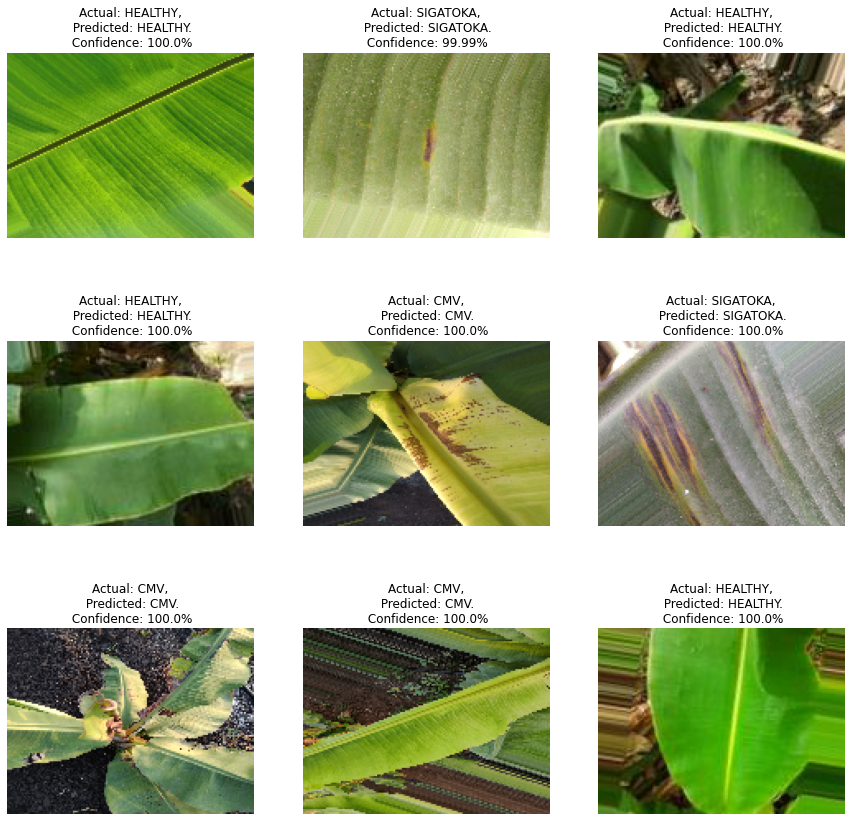

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

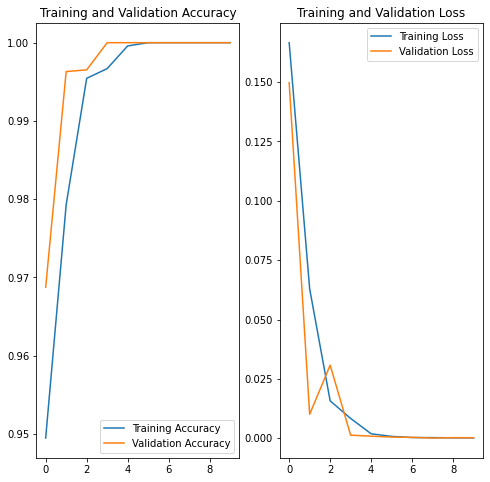

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#from PIL import Image
#PERFORMING PREDICTIONS ON UNKNOWN IMAGES
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from keras.preprocessing.image import load_img
import numpy as np
import os
#/content/drive/MyDrive/UNTRAINED DATA/UNTRAINED_SIGATOKA.jpg
for image in os.listdir("/content/drive/MyDrive/UNTRAINED_DATA"):
  #img = load_img(image)
  # print("/content/drive/MyDrive/UNTRAINED_DATA"+image)
   #img=img.resize((113,150))
   print(image)
   img = load_img("/content/drive/MyDrive/UNTRAINED_DATA/"+image)
   img=img.resize((150,113))
   img_array = tf.keras.preprocessing.image.img_to_array(img)
   img_array = tf.expand_dims(img_array, 0)
   print(np.argmax(resnet_model.predict(img_array)))

UNTRAINED_CMV.jpeg
0
UNTRAINED_SIGATOKA.jpg
2
UNTRAINED_SIGATOKA_1.jpg
2
sigatoka_images.jpg
2
yellow-sigatoka-banana-1563270070.jpg
2
yellow-sigatoka-banana-1563270133.jpg
2
yellow-sigatoka-banana-1563270070 (1).jpg
2
healthy (1).jpg
1
healthy.jpg
0
unknown.jpg
0
cmv_6.jpeg
0
cmv_5.jpeg
0
cmv_4.jpeg
0
cmv_3.jpeg
0
cmv_2.jpeg
0
cmv_1.jpeg
0


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred=resnet_model.predict(test_ds)


In [ ]:
labels_predicted=[]
for y in y_pred:
  labels_predicted.append(np.argmax(y))

In [ ]:
len(labels_predicted)

320

In [ ]:
for i in range(320):
  lable_list[i] = int(lable_list[i])

In [ ]:
cm = confusion_matrix(lable_list, labels_predicted)

In [ ]:
import pandas as pd
cm_df = pd.DataFrame(cm,
                     index = ['CMV','HEALTHY','SIGATOKA'],
                     columns = ['CMV','HEALTHY','SIGATOKA'])

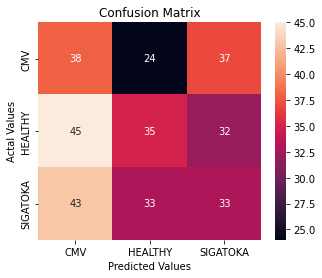

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/FINAL_RESNET_MODEL") + [0]])+1
resnet_model.save(f"/content/drive/MyDrive/FINAL_RESNET_MODEL/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL_RESNET_MODEL/2/assets
